<a href="https://colab.research.google.com/github/MojiDZ/timeSeriesForcastingTimesFM/blob/main/NASAjetEngine_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 6.8 MB/s eta 0:00:00


In [ ]:
import math
import os

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

from catboost import CatBoostClassifier

In [ ]:
path = "/content/drive/MyDrive/CMAPSSData/test_FD001.txt"

eda_trainset1 = pd.read_csv(path, sep=" ", header=None)

eda_trainset1.head()

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735,NaN,NaN
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916,NaN,NaN
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166,NaN,NaN
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737,NaN,NaN
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130,NaN,NaN


<Axes: >

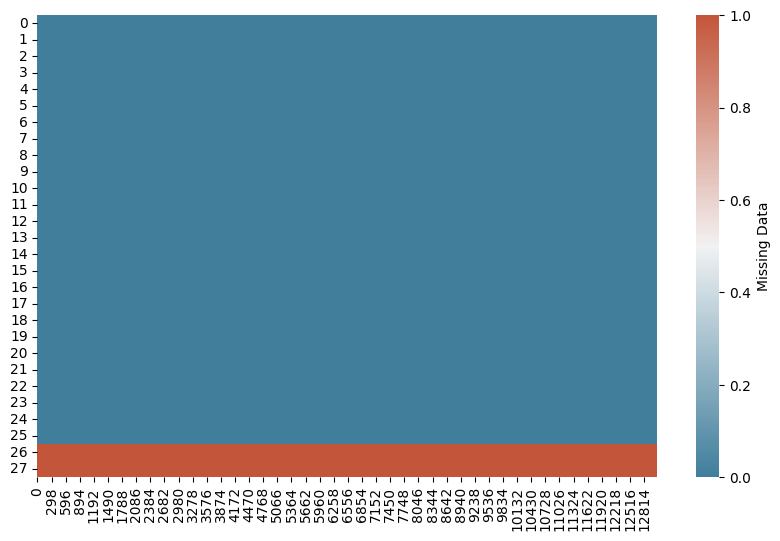

In [ ]:
plt.figure(figsize=(10,6))
sns.heatmap(eda_trainset1.isna().transpose(),
            cmap = sns.diverging_palette(230, 20, as_cmap=True),
            cbar_kws={'label': 'Missing Data'})

In [ ]:
eda_trainset1.isna().sum()

0         0
1         0
2         0
3         0
4         0
5         0
6         0
7         0
8         0
9         0
10        0
11        0
12        0
13        0
14        0
15        0
16        0
17        0
18        0
19        0
20        0
21        0
22        0
23        0
24        0
25        0
26    13096
27    13096
dtype: int64

In [ ]:
trainset1_copy = eda_trainset1.drop([26,27], axis=1)

In [ ]:
column_names = ["unit_number","time_in_cycles","setting1","setting2","setting3",
                "s01","s02",
                "s03","s04",
                "s05","s06",
                "s07","s08",
                "s09","s10",
                "s11","s12",
                "s13","s14",
                "s15","s16",
                "s17","s18",
                "s19","s20",
                "s21"]

trainset1_copy.columns = column_names
trainset1_copy.head()

,unit_number,time_in_cycles,setting1,setting2,setting3,s01,s02,s03,s04,s05,...,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,521.72,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,522.16,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,521.97,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,521.38,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,522.15,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130


In [ ]:
trainset1_copy.describe().T

,count,mean,std,min,25%,50%,75%,max
unit_number,13096.0,51.543907,2.828942e+01,1.0000,28.0000,52.0000,76.0000,100.0000
time_in_cycles,13096.0,76.836515,5.305775e+01,1.0000,33.0000,69.0000,113.0000,303.0000
setting1,13096.0,-0.000011,2.202685e-03,-0.0082,-0.0015,-0.0000,0.0015,0.0078
setting2,13096.0,0.000004,2.940306e-04,-0.0006,-0.0002,-0.0000,0.0003,0.0007
setting3,13096.0,100.000000,0.000000e+00,100.0000,100.0000,100.0000,100.0000,100.0000
s01,13096.0,518.670000,0.000000e+00,518.6700,518.6700,518.6700,518.6700,518.6700
s02,13096.0,642.475088,4.008993e-01,641.1300,642.1975,642.4600,642.7400,644.3000
s03,13096.0,1588.099204,5.003274e+00,1569.0400,1584.6000,1587.9900,1591.3625,1607.5500
s04,13096.0,1404.735362,6.688309e+00,1384.3900,1399.9500,1404.4400,1409.0500,1433.3600
s05,13096.0,14.620000,1.776425e-15,14.6200,14.6200,14.6200,14.6200,14.6200


# columns show low std and mean == min/max --they wont help in training.   "s19","s18","s16","s10","s05","s01","setting3"

In [ ]:
trainset1_copy = trainset1_copy.drop(["s19","s18","s16","s10","s05","s01","setting3"], axis=1)

<Axes: >

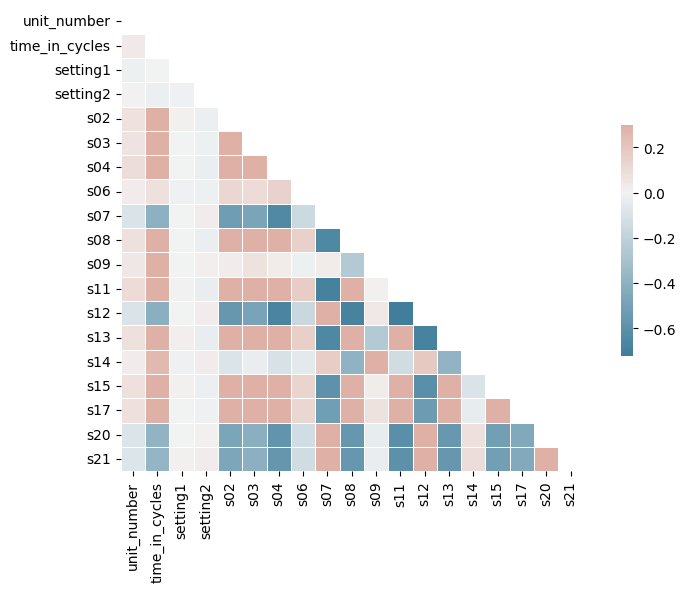

In [ ]:
corr = trainset1_copy.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(10, 6))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr,mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [ ]:
trainset1_copy = trainset1_copy.drop(["setting1","setting2","s06", "s14"], axis=1) #unit_number will be removed later

In [ ]:
# Making an array which contains EOL of all the Ids
EOL=[]
for i in trainset1_copy['unit_number']:
        EOL.append( ((trainset1_copy[trainset1_copy['unit_number'] == i]["time_in_cycles"]).values)[-1])

trainset1_copy["EOL"]=EOL

# Calculate "LR"
trainset1_copy["LR"] = trainset1_copy["time_in_cycles"].div(trainset1_copy["EOL"])

trainset1_copy['label'] = pd.cut(trainset1_copy['LR'], bins=[0, 0.6, 0.8, np.inf], labels=[0, 1, 2], right=False)

trainset1_copy.drop(columns=['unit_number', 'EOL', 'LR'], inplace=True)

trainset1_copy.head()

,time_in_cycles,s02,s03,s04,s07,s08,s09,s11,s12,s13,s15,s17,s20,s21,label
0,1,643.02,1585.29,1398.21,553.90,2388.04,9050.17,47.20,521.72,2388.03,8.4052,392,38.86,23.3735,0
1,2,641.71,1588.45,1395.42,554.85,2388.01,9054.42,47.50,522.16,2388.06,8.3803,393,39.02,23.3916,0
2,3,642.46,1586.94,1401.34,554.11,2388.05,9056.96,47.50,521.97,2388.03,8.4441,393,39.08,23.4166,0
3,4,642.44,1584.12,1406.42,554.07,2388.03,9045.29,47.28,521.38,2388.05,8.3917,391,39.00,23.3737,0
4,5,642.51,1587.19,1401.92,554.16,2388.01,9044.55,47.31,522.15,2388.03,8.4031,390,38.99,23.4130,0


Evaluation Methods

In [ ]:
def score_func(y_true,y_pred):
    """
    model evaluation function

    Args:
        y_true = true target RUL value
        y_pred = predicted target RUL value
    """
    mae = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    r2 = r2_score(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    report = classification_report(y_true, y_pred)
    score_list = [round(mae, 2), round(rmse, 2), round(r2, 2)]
    # printing metrics
    print("Classification Report:\n", report)
    print(f' Mean Absolute Error (MAE): {score_list[0]}')
    print(f' Root Mean Squared Error (RMSE): {score_list[1]}')
    print(f' R2 Score: {score_list[2]}')
    print("<)-------------X-------------(>")

In [ ]:
def plot_confmatrix(y_true,y_pred):
    confm = confusion_matrix(y_true, y_pred)
    df_cm = pd.DataFrame(confm, index=sorted(set(y_true)), columns=sorted(set(y_true)))

    return sns.heatmap(df_cm, cmap = sns.diverging_palette(230, 20, as_cmap=True) , annot=True, fmt='d')

# DATA MANAGMENT

In [ ]:
def transform_df(file_path):
    # Read CSV file into a DataFrame
    df = pd.read_csv(file_path, sep=" ", header=None)
    df = df.drop([26,27], axis=1)
    column_names = ["unit_number","time_in_cycles","setting1","setting2","setting3",
                "s01","s02","s03","s04","s05","s06","s07","s08","s09","s10","s11","s12","s13",
                "s14","s15","s16","s17","s18","s19","s20","s21"]

    df.columns = column_names
    # Drop specified columns
    columns_to_drop = ["s19", "s18", "s16", "s10", "s05", "s01", "setting3",
                       "setting1", "setting2", "s06", "s14"]
    df = df.drop(columns=columns_to_drop, axis=1)

    # Making an array which contains EOL of all the Ids
    EOL = []
    for i in df['unit_number']:
        EOL.append(((df[df['unit_number'] == i]['time_in_cycles']).values)[-1])

    df["EOL"] = EOL

    # Calculate "LR"
    df["LR"] = df["time_in_cycles"].div(df["EOL"])

    # Calculate RUL
    df["RUL"] = df["EOL"] - df["time_in_cycles"]

    # Create 'label' column based on RUL threshold
    df['label'] = (df['RUL'] <= 50).astype(int)  # 0 if RUL <= 50, 1 otherwise

    # Drop unnecessary columns
    df.drop(columns=['unit_number', 'EOL', 'LR', 'RUL'], inplace=True)

    X_train = df.drop(["label"], axis=1).values
    y_train = df["label"]

    return X_train, y_train

ML

In [ ]:
trainset_path = "/content/drive/MyDrive/CMAPSSData/train_FD001.txt"
X_train, y_train = transform_df(trainset_path)
print(f"Dimension of feature matrix : {X_train.shape}\ndimension of target vector: {y_train.shape}")

Dimension of feature matrix : (20631, 14)
dimension of target vector: (20631,)


In [ ]:
testset_path ="/content/drive/MyDrive/CMAPSSData/test_FD001.txt"
X_test, y_test = transform_df(testset_path)
print(f"Dimension of feature matrix : {X_train.shape}\ndimension of target vector: {y_train.shape}")

Dimension of feature matrix : (20631, 14)
dimension of target vector: (20631,)


In [ ]:
X_train_def, X_val_def, y_train_def, y_val_def = train_test_split(X_train, y_train, test_size=0.30, random_state=7)

In [ ]:
model = CatBoostClassifier(iterations=100,
                           loss_function="MultiClass",
                           classes_count=2,
                           verbose=False)

# Fit model on training data
model.fit(X_train_def, y_train_def)

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.97      0.96      4651
           1       0.90      0.83      0.86      1539

    accuracy                           0.93      6190
   macro avg       0.92      0.90      0.91      6190
weighted avg       0.93      0.93      0.93      6190

 Mean Absolute Error (MAE): 0.07
 Root Mean Squared Error (RMSE): 0.26
 R2 Score: 0.64
<)-------------X-------------(>


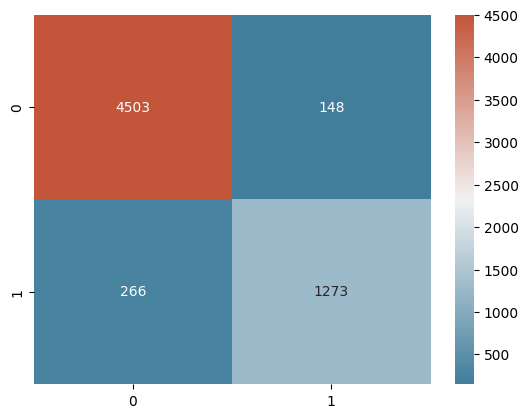

In [ ]:
y_pred_def1 = model.predict(X_val_def)

# Evaluate the model & print metrics
plot_confmatrix(y_val_def,y_pred_def1)
score_func(y_val_def,y_pred_def1)

Classification Report:
               precision    recall  f1-score   support

           0       0.65      1.00      0.79      8070
           1       0.95      0.14      0.25      5026

    accuracy                           0.67     13096
   macro avg       0.80      0.57      0.52     13096
weighted avg       0.77      0.67      0.58     13096

 Mean Absolute Error (MAE): 0.33
 Root Mean Squared Error (RMSE): 0.58
 R2 Score: -0.41
<)-------------X-------------(>


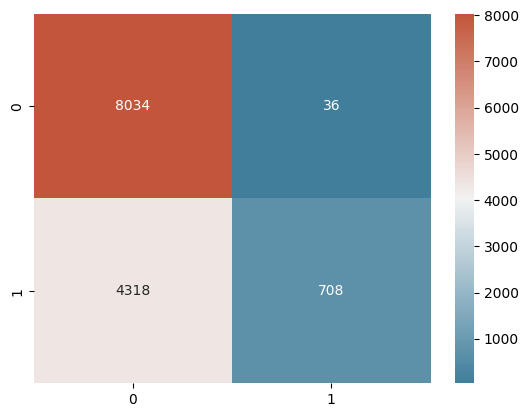

In [ ]:
y_pred_def2 = model.predict(X_test)

# Evaluate the model & print metrics
plot_confmatrix(y_test,y_pred_def2)
score_func(y_test,y_pred_def2)

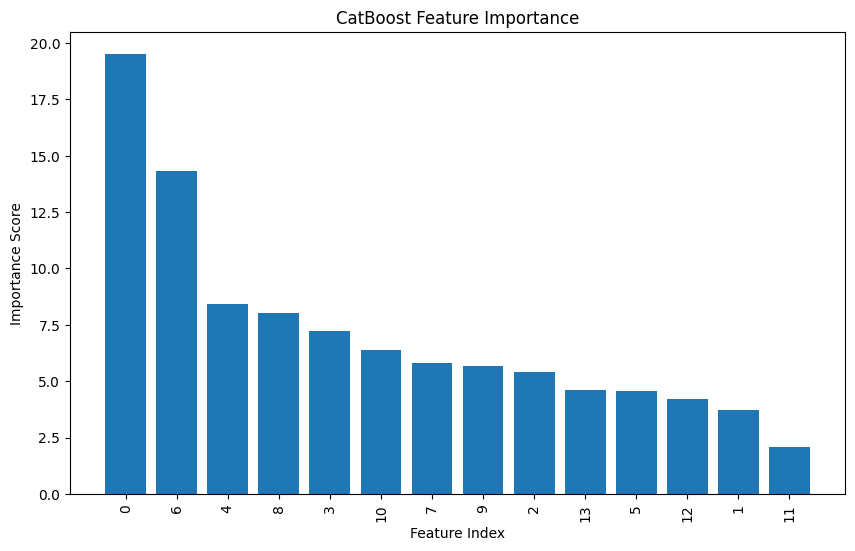

In [ ]:
importances = model.feature_importances_

# Sort and visualize
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.bar(range(len(importances)), importances[indices])
plt.xticks(range(len(importances)), indices, rotation=90)  # Using indices instead of feature names
plt.xlabel('Feature Index')
plt.ylabel('Importance Score')
plt.title('CatBoost Feature Importance')
plt.show()

In [ ]:
idx_to_remove = [11]
X_train_new = np.delete(X_train, idx_to_remove, axis=1)
X_test_new = np.delete(X_test, idx_to_remove, axis=1)
print(f"New Dimension : {X_train_new.shape}\nNew Dimension (testset): {X_test_new.shape}")

New Dimension : (20631, 13)
New Dimension (testset): (13096, 13)


**Training: After Feature Analysis**

In [ ]:
X_train_fa, X_val_fa, y_train_fa, y_val_fa = train_test_split(X_train_new, y_train, test_size=0.30, random_state=7)

model = CatBoostClassifier(iterations=100,
                           loss_function="MultiClass",
                           classes_count=2,
                           verbose=False)

# Fit model on training data
model.fit(X_train_fa, y_train_fa)

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.97      0.95      4651
           1       0.89      0.82      0.86      1539

    accuracy                           0.93      6190
   macro avg       0.92      0.90      0.91      6190
weighted avg       0.93      0.93      0.93      6190

 Mean Absolute Error (MAE): 0.07
 Root Mean Squared Error (RMSE): 0.26
 R2 Score: 0.63
<)-------------X-------------(>


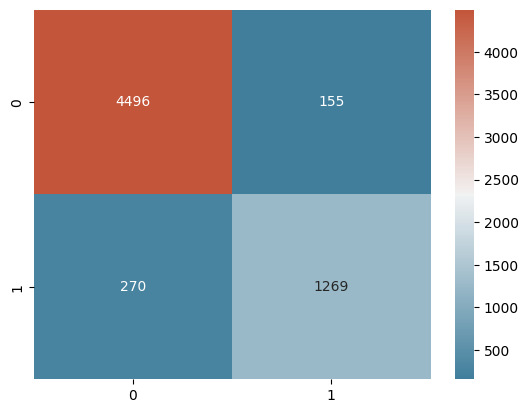

In [ ]:
y_pred_fa1 = model.predict(X_val_fa)

# Evaluate the model & print metrics
plot_confmatrix(y_val_fa,y_pred_fa1)
score_func(y_val_fa,y_pred_fa1)

Classification Report:
               precision    recall  f1-score   support

           0       0.65      1.00      0.79      8070
           1       0.95      0.14      0.25      5026

    accuracy                           0.67     13096
   macro avg       0.80      0.57      0.52     13096
weighted avg       0.77      0.67      0.58     13096

 Mean Absolute Error (MAE): 0.33
 Root Mean Squared Error (RMSE): 0.58
 R2 Score: -0.41
<)-------------X-------------(>


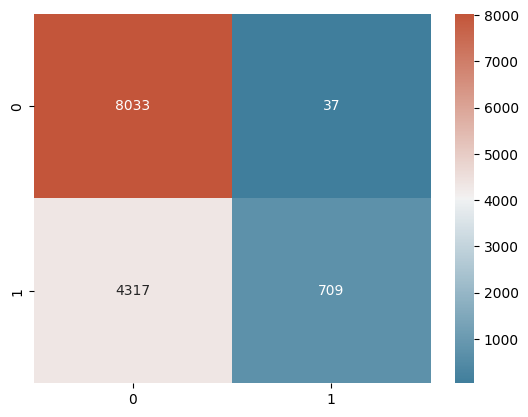

In [ ]:
y_pred_fa2 = model.predict(X_test_new)

# Evaluate the model & print metrics
plot_confmatrix(y_test,y_pred_fa2)
score_func(y_test,y_pred_fa2)

# Hyperparametes Tuning

In [ ]:

param_dist_catboost = {
    'iterations': [64, 128],
    'learning_rate': [0.01, 0.05, 0.1],
    'depth': [4, 6, 8, 10],
    'l2_leaf_reg': [0.001,0.05, 0.01, 0.1],
    'loss_function':["MultiClass"],
    'verbose':[False],
    'auto_class_weights': ['SqrtBalanced','Balanced','None']
}

# Create CatBoost model
catboost_model = CatBoostClassifier()

# Perform RandomizedSearchCV for CatBoost
random_search_catboost = RandomizedSearchCV(
    catboost_model, param_distributions=param_dist_catboost,
    n_iter=10, cv=5, scoring='f1_macro', random_state=7, verbose=1, n_jobs=-1)

random_search_catboost.fit(X_train_new, y_train)

# Access the best CatBoost model
best_catboost = random_search_catboost.best_estimator_
print("Best Hyperparameters for CatBoost:", random_search_catboost.best_params_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Hyperparameters for CatBoost: {'verbose': False, 'loss_function': 'MultiClass', 'learning_rate': 0.05, 'l2_leaf_reg': 0.1, 'iterations': 128, 'depth': 10, 'auto_class_weights': 'None'}


In [ ]:
X_train_hp, X_val_hp, y_train_hp, y_val_hp = train_test_split(X_train_new, y_train, test_size=0.30, random_state=7)

In [ ]:
model = CatBoostClassifier(iterations=128,
                           learning_rate = 0.01,
                           loss_function="MultiClass",
                           classes_count=2,
                           l2_leaf_reg=0.01,
                           depth=10,
                           auto_class_weights='SqrtBalanced',
                           verbose=False)

# Fit model on training data
model.fit(X_train_hp, y_train_hp)

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.96      0.95      4651
           1       0.86      0.86      0.86      1539

    accuracy                           0.93      6190
   macro avg       0.91      0.91      0.91      6190
weighted avg       0.93      0.93      0.93      6190

 Mean Absolute Error (MAE): 0.07
 Root Mean Squared Error (RMSE): 0.26
 R2 Score: 0.63
<)-------------X-------------(>


<Axes: >

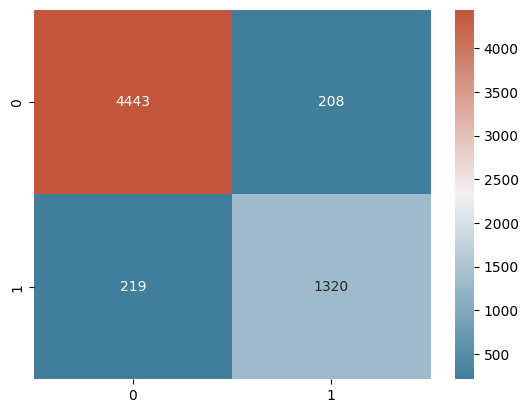

In [ ]:
y_pred_hp1 = model.predict(X_val_hp)

# Evaluate the model & print metrics
score_func(y_val_hp,y_pred_hp1)

plot_confmatrix(y_val_hp,y_pred_hp1)

Classification Report:
               precision    recall  f1-score   support

           0       0.65      1.00      0.79      8070
           1       0.96      0.16      0.27      5026

    accuracy                           0.67     13096
   macro avg       0.80      0.58      0.53     13096
weighted avg       0.77      0.67      0.59     13096

 Mean Absolute Error (MAE): 0.33
 Root Mean Squared Error (RMSE): 0.57
 R2 Score: -0.38
<)-------------X-------------(>


<Axes: >

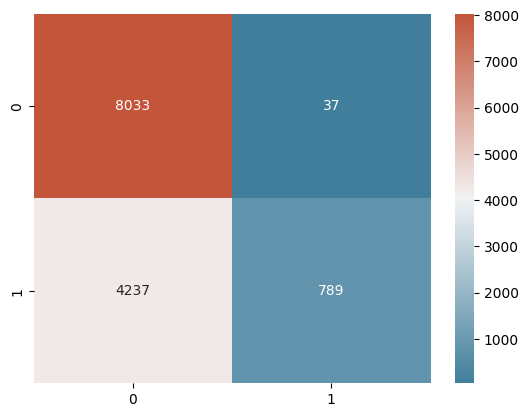

In [ ]:
y_pred_hp2 = model.predict(X_test_new)

# Evaluate the model & print metrics
score_func(y_test,y_pred_hp2)

plot_confmatrix(y_test,y_pred_hp2)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
model = RandomForestClassifier(random_state=7)  # Set random_state for reproducibility
model.fit(X_train, y_train)

RandomForestClassifier(random_state=7)

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
from sklearn.metrics import accuracy_score, classification_report

accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print("Classification Report:\n", report)

Accuracy: 0.6647067806963959
Classification Report:
               precision    recall  f1-score   support

           0       0.65      1.00      0.79      8070
           1       0.97      0.13      0.23      5026

    accuracy                           0.66     13096
   macro avg       0.81      0.56      0.51     13096
weighted avg       0.77      0.66      0.57     13096



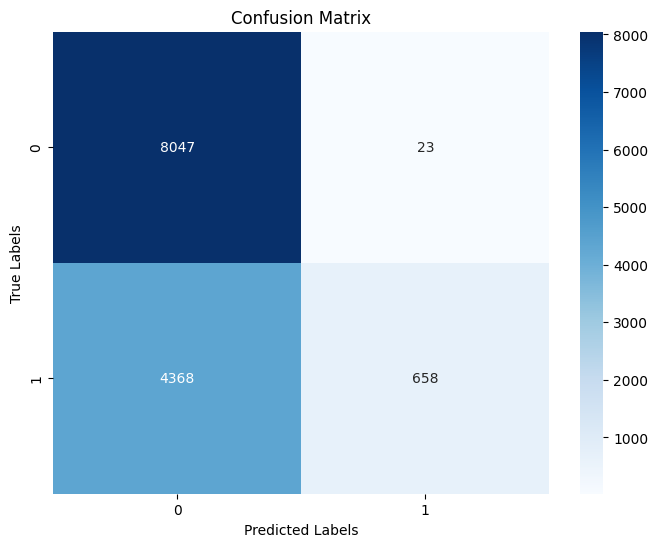

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

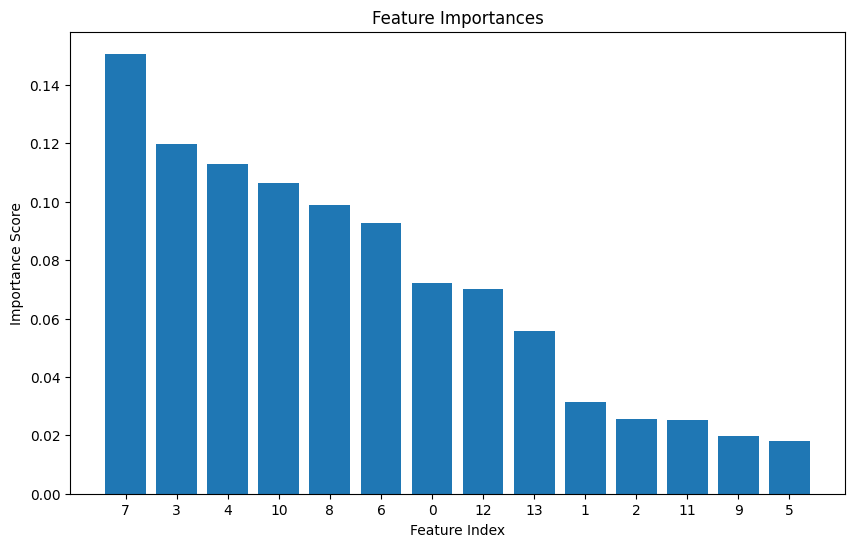

In [ ]:
# Get feature importances
importances = model.feature_importances_

# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.bar(range(X_train.shape[1]), importances[indices])
plt.xticks(range(X_train.shape[1]), indices)
plt.xlabel('Feature Index')
plt.ylabel('Importance Score')
plt.title('Feature Importances')
plt.show()

# SVM

In [ ]:
from sklearn.svm import SVC

In [ ]:
model = SVC(kernel='rbf', random_state=7)  # You can choose different kernels like 'linear', 'poly', etc.
model.fit(X_train, y_train)

SVC(random_state=7)

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
from sklearn.metrics import accuracy_score, classification_report

accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print("Classification Report:\n", report)

Accuracy: 0.6162186927306048
Classification Report:
               precision    recall  f1-score   support

           0       0.62      1.00      0.76      8070
           1       0.00      0.00      0.00      5026

    accuracy                           0.62     13096
   macro avg       0.31      0.50      0.38     13096
weighted avg       0.38      0.62      0.47     13096



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


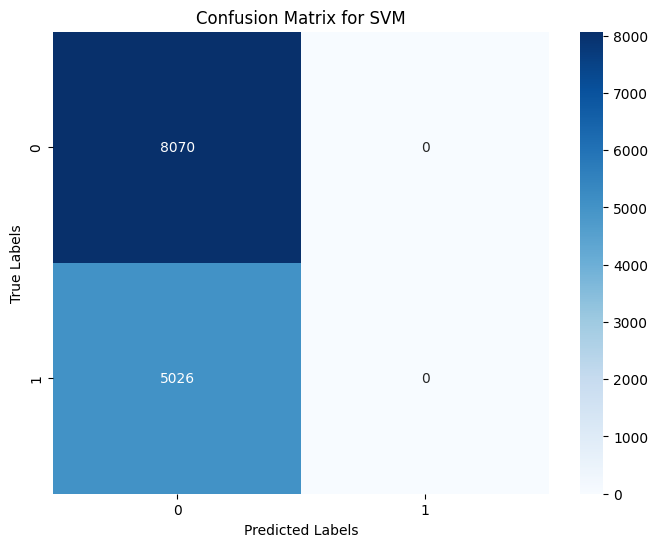

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for SVM')
plt.show()

# PCA


In [ ]:
from sklearn.decomposition import PCA

In [ ]:
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

In [ ]:
model = RandomForestClassifier(random_state=7)  # Or your preferred classifier
model.fit(X_train_pca, y_train)

RandomForestClassifier(random_state=7)

Accuracy: 0.6728772144166157
Classification Report:
               precision    recall  f1-score   support

           0       0.66      0.98      0.79      8070
           1       0.86      0.18      0.29      5026

    accuracy                           0.67     13096
   macro avg       0.76      0.58      0.54     13096
weighted avg       0.74      0.67      0.60     13096



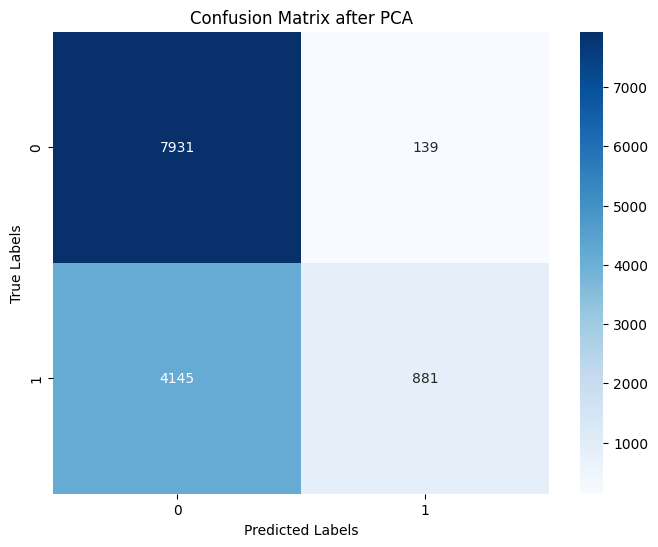

In [ ]:
# Predict on the test set
y_pred = model.predict(X_test_pca)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# Generate classification report
report = classification_report(y_test, y_pred)
print("Classification Report:\n", report)

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix after PCA')
plt.show()

# DEEP LEARNING PART

In [ ]:
!pip install ipynb
!pip install nbformat
!pip install git+https://github.com/google-research/timesfm.git
!pip install utilsforecast
!pip install prophet

  Cloning https://github.com/google-research/timesfm.git to /tmp/pip-req-build-zfy5_eli
  Running command git clone --filter=blob:none --quiet https://github.com/google-research/timesfm.git /tmp/pip-req-build-zfy5_eli
  Resolved https://github.com/google-research/timesfm.git to commit 5c7b905e8deccad1a026a9475b00777fbadc0b18
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
